Suppose a continuous variables $X$ and discrete variable $Y$. For a specific number of $k$ quantization on $X$, we will have a set of $j$ RP trees $\{T_1, T_2, \dots, T_j\}$. For example, in one tree $T_m$, suppose it has $k$ number of leaves(bins) $\{L_1, \dots, L_k\}$. In each leaf $L_i$, if assume $Y$ is binary variable, we have $n_0^{(i)}, n_1^{(i)}$, where $n_0, n_1$ is the number of points which has target variables $\{0, 1\}$. Thus, for this leaf, we have negative loglikelihood $l^{(i)}$ can be defined as:
$$
l_i = -n_1^{(i)} \log\frac{n_1^{(i)}}{n^{(i)}} - n_0^{(i)} \log\frac{n_0^{(i)}}{n^{(i)}} \enspace.
$$,
where $n^{(i)} = n_0^{(i)} + n_1^{(i)}$

The __AIC__ of $T_m$ can be computed by adding number of bins $k$:
$$AIC(T_m) = \sum_1^{k} l_i + k$$

## AIC

In [1]:
# 2 relevant variables + 2 irrelevant variables
from RPTree import *
from estimators import *
from os import listdir
from os.path import isfile, join
import pandas as pd
mypath = 'data/sampledNonLinData/2/2/2-2-0.45832/50RandomDatasetsFromNetworkWithNumSamples_0000000040/'
def read_file(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    sublist = []
    for each in onlyfiles:
        sub = pd.read_csv(mypath + each)
        sub.columns=['X1', 'X2', 'X3', 'X4', 'Y'] 
        sublist.append(sub)

    df = pd.concat(sublist)
    df = df[['X1', 'X2', 'Y']]
    return df

# df=read_file(mypath)
# df

In [2]:
from RPTree import *
from estimators import *
from copy import deepcopy

def run(X, y, MinSize, y_dic, estimator='naive_estimate', set_bins=None, types='median'):
    """n represents how many dimensions, can't do repeatation
    """
    tree = RPTree(X)
    tree_made = tree.MakeTree(MinSize, types=types)
    if set_bins and tree_made.counts() != set_bins:
        return [None] * 4
    all_entropy, bins, depth = get_entropy(tree_made, y_dic, MinSize, estimator=estimator)
    res, L = all_entropy[X]['entropy'], all_entropy[X]['loglikelihood'] # main entropy
    est = eval(estimator)
    y_entropy = est(y)
    aic = L + bins
    return 1-res/y_entropy, L, bins, depth, aic, MinSize, all_entropy

In [3]:
mypath = listdir('data/sampledNonLinData/2/2/2-2-0.45832/')
all_files = [read_file('data/sampledNonLinData/2/2/2-2-0.45832/' + each + '/') for each in mypath]
all_files = [(each.shape, each) for each in all_files]
all_files.sort()
all_files = [each[1] for each in all_files]

In [4]:
result_dic = {}

final_aic, final_fmi, final_bin = 0, 0, 0
sizes = [i for i in range(2, 101)]
for df in all_files:
    all_result = {}
    aic_result = {}
    entro_result = {}
    entro_dic_result = {}
    x_lst = tuple([tuple(each) for each in df[['X1', 'X2']].values.tolist()])
    y_dic = dict(zip(x_lst, df.Y.values.tolist()))
    X, Y = x_lst, df.Y.values
    print('Start: ' , df.shape[0])
    if df.shape[0] > 10000:
        print('Stop')
        break
    for rep in range(5):
        for size in sizes:
            fmi, L, bins, depth, aic, MinSize, entropy_dic = run(X, Y, size, y_dic, estimator='naive_estimate')
            if bins not in all_result:
                all_result[bins] = [fmi]
                aic_result[bins] = [aic]
                entro_result[bins] = [L]
                entro_dic_result[bins] = [entropy_dic]
            else:
                all_result[bins].append(fmi)
                aic_result[bins].append(aic)
                entro_result[bins].append(L)
                entro_dic_result[bins].append(entropy_dic)

            if not final_aic or final_aic > aic:
                final_aic = aic
                final_fmi = fmi
                final_bin = bins
                
    result_dic[df.shape[0]] = [all_result, aic_result, entro_result, entro_dic_result]
    print("Finished")     

Start:  950
Finished
Start:  1950
Finished
Start:  3950
Finished
Start:  7950


KeyboardInterrupt: 

In [5]:
# import pickle

# with open('RP_tree_1_only_Relevant_Variables_.p', 'wb') as fp:
#     pickle.dump(result_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# import pickle

# with open('RP_tree_1_only_Relevant_Variables_.p', 'rb') as fp:
#     result_dic = pickle.load(fp)

In [8]:
final_aic, final_fmi

(334.8421459990832, 0.47767396872515655)

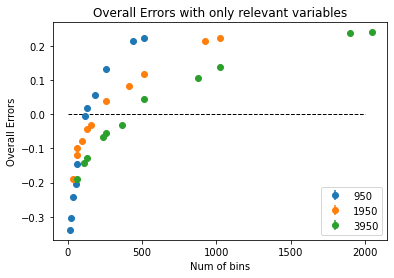

In [8]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

def bias_std(dic):
    """
    dic = result_dic[key]
    """
    bias_lst = [np.mean(dic[key])-0.45832 for key in dic]
    std_lst = [np.std(dic[key]) for key in dic]
    summ = pd.DataFrame({'Mean': bias_lst, 'std': std_lst})
    summ.index = list(dic.keys())
    return summ


fig, ax11 = plt.subplots(sharex=True, sharey=False)
ax11.set_xlabel('Num of bins')
ax11.set_title('Overall Errors with only relevant variables')
ax11.set_ylabel('Overall Errors')
for key in result_dic:
    summ = bias_std(result_dic[key][0])
    summ = summ.sort_index()
    ind = summ.index
    y = summ[f'Mean']
    yerr = summ[f'std'].values
    ax11.errorbar(ind, y, yerr=yerr, fmt='o', label=str(key))


ax11.hlines(0, xmin=0, xmax=2000, color='k', linestyle='dashed', linewidth=1)
ax11.legend()
plt.show()

__Averaging the models__
Suppose we have an estimator $\theta^{(k)}$ to control the number of bins $k$. By applying this estimator in RP-trees on dataset, we have a set of RP-trees $(T_m = \{T_0, \dots, T_i\})$. For a RP-tree $T_i$, we have a y distribution $p(y|T^{(i)})$. If we consider the overall y distirbution on the whole data from these RP-trees, it can be a mixture model of different weighted RP-trees. 
$$
P(y) = \sum_i^k w_i p(y|T_i) \enspace.
$$,
where $w_i \propto e^{-AIC(T_i)}, \sum w_i = 1$.
Thus, we have
\begin{align}
I(X;Y) &= H(Y) - H(Y|X)\\
&= -\sum_i^k w_i p(y|T_i) \log p(y|T_i) + \sum_i^k w_i p((y|x)|T_i) \log p((y|x)|T_i)
\end{align}

In [275]:
def find_y(dic):
    new_y_lst = []
    for each in dic:
        new_y = []
        for key in each.keys(): 
            if "main" in each[key]:
                a, b = each[key]['main']
                a, b = list(a), list(b)
                if len(a) == 1:
                    new_y += a*b[0]
                else:
                    new = [a[0]] * b[0] + [a[1]] * b[1]
                    new_y += [np.mean(new)] * (b[0] + b[1])
                        
        entro = entropy(np.array(new_y))
        new_y_lst.append(entro)
    return np.array(new_y_lst)


def ave_model(result_dic, n):
    weights = [math.exp(-each) for code in result_dic[n][1].keys() for each in result_dic[n][1][code]]
    para = 1/sum(weights)
    weights = np.array([para * each for each in weights])

    entro = [each/n for code in result_dic[n][2].keys() for each in result_dic[n][2][code]]
    norm_entro = sum(np.array(entro) * weights)

    entro_y = []
    for key in result_dic[n][3].keys():
        for code in find_y(result_dic[n][3][key]):
            entro_y.append(code)
            
    entro_y = sum((np.array(entro_y) * weights))
    return 1 - norm_entro/entro_y

for key in result_dic.keys():
    print("n:", key, "FMI: ", ave_model(result_dic, key))

n: 950 FMI:  0.8731058961204365
n: 1950 FMI:  0.9108263868535811


ZeroDivisionError: float division by zero